In [ ]:
%load_ext autoreload
%autoreload 2

# PriorVAE: Comparisons of scaling

In [ ]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [ ]:
from reusable.util import gen_file_name, get_decoder_params, load_training_history, load_training_state, load_args
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi
from flax.core.frozen_dict import freeze
from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE



rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)



In [ ]:
from reusable.util import update_args_11


def plot_experiment(experiment, count):
    temp_args = load_args("11", count, experiment+"_args")


    gp_draws = plot_gp_predictive(rng_key_gp, x=temp_args["x"], gp_kernel=temp_args["gp_kernel"], jitter=1e-5)["y"]

    exp_args = temp_args["11_" + experiment]

    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"])


    for loss_fn in temp_args["loss_fns"]:
        

        training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
        training_fig.suptitle(
            f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']}Test/train for loss fn {loss_fn}",
            fontsize=40,
        )

        comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
        comp_fig.suptitle(
            f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} comparison plots for {loss_fn}",
            fontsize=40,
        )

        plot_draws_hpdi(gp_draws, temp_args["x"], f"GP draws", "$y=f_{GP}(x)$", "GP", ax=comp_axs[0, 0])

        for j in range(1, len(exp_args["Brange"])):
            comp_axs[0, j].remove()

        for i, a in enumerate(exp_args["Arange"]):
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment+"_args")

                args = update_args_11(args, args["11_"+experiment], i, j)

                index = i + j * aL
                try:
                    metrics_history = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))

                    
                    plot_training(
                        metrics_history["test_loss"],
                        metrics_history["train_loss"],
                        f"Test/train loss for {exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}",
                        "loss",
                        training_axs[i, j],
                    )

                    dummy = VAE(
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        conditional=False,
                    )
                    dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

                    decoder_params = get_decoder_params(load_training_state("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"), dummy_params))

                  
                    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
                    vae_draws = plot_vae_predictive(
                        rng_key_predict,
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        decoder_params=decoder_params,
                    )["f"]

                    plot_draws_hpdi(
                        vae_draws,
                        args["x"],
                        f"{exp_args['Adesc']}={a}, {exp_args['Bdesc']}={b}",
                        "$y=f_{VAE}(x)$",
                        "VAE",
                        ax=comp_axs[i + 1, j],
                    )

                except FileNotFoundError:
                    print(f"Failed to load a={a}, b={b}")


# Grid of training plots

In [ ]:
plot_experiment("exp5", "4")

In [20]:
import numpy as onp
from plotting.plots import plot_times_matrix, plot_times_graph


def correct_timing(history, prev_hists):
    """Issue: epoch (and batch times), reset every so often, as I didn't add the times up when rerunning the training"""
    if len(prev_hists) == 0:
        return history

    history["epoch_times"] = history["epoch_times"] + prev_hists[-1]["epoch_times"][-1]
    history["batch_times"] = history["batch_times"] + prev_hists[-1]["epoch_times"][-1]

    return history


def plot_experiment_times(experiment, count, needs_timing_correction=False):
    temp_args = load_args("11", count, experiment+"_args")


    exp_args = temp_args["11_" + experiment]
    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"])


    for loss_fn in temp_args["loss_fns"]:
        histories = []


        for i, a in enumerate(exp_args["Arange"]):
            i_hists = []
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment+"_args")

                args = update_args_11(args, args["11_"+experiment], i, j)

                index = i + j * aL
            

                try:
                    h = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))
                    
           
                    if needs_timing_correction:
                        h = correct_timing(h, i_hists)
                    i_hists.append(h)

                except FileNotFoundError:
                    i_hists.append({"interrupted": True})
                    print(f"Failed to load a={a}, b={b}")
            histories.append(i_hists)
            
        full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories])

        interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
        full_epochs = onp.array([[len(h["epoch_times"])if "epoch_times" in h else float('nan') for h in hs] for hs in histories])
        # matrix of A x B, showing times
        plot_times_matrix(
            full_times,
            interrupted,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"{experiment}: row:{exp_args['Adesc']}, col:{exp_args['Bdesc']} TIMES for loss fn {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_matrix.png",
        )
        # graph of x=A, y=time, curve per B

        plot_times_graph(
            full_times,
            exp_args["Brange"],
            exp_args["Arange"],
            exp_args["Bdesc"],
            exp_args["Adesc"],
            f"time vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVb.png",
        )
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            full_times.T,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"time vs {exp_args['Adesc']}, loss fn: {loss_fn}",
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVa.png",
        )

        # same graphs, but just increase from initial:
        initial_times = full_times[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

        plot_times_graph(
            full_times - initial_times,
            exp_args["Brange"],
            exp_args["Arange"],
            exp_args["Bdesc"],
            exp_args["Adesc"],
            f"time change vs {exp_args['Bdesc']}, loss fn: {loss_fn}",
            is_relative=True,
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVb_change.png",
        )

        initial_times = full_times.T[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            full_times.T - initial_times,
            exp_args["Arange"],
            exp_args["Brange"],
            exp_args["Adesc"],
            exp_args["Bdesc"],
            f"time change vs {exp_args['Adesc']}, loss fn: {loss_fn}",
            is_relative=True,
            save_path=f"./gen_plots/11/{experiment}_{loss_fn}_timeVa_change.png",
        )


/home/max/4yp/plotting/plots.py:327: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Failed to load a=200, b=400
Failed to load a=225, b=350
Failed to load a=225, b=400
Failed to load a=250, b=300
Failed to load a=250, b=350
Failed to load a=250, b=400


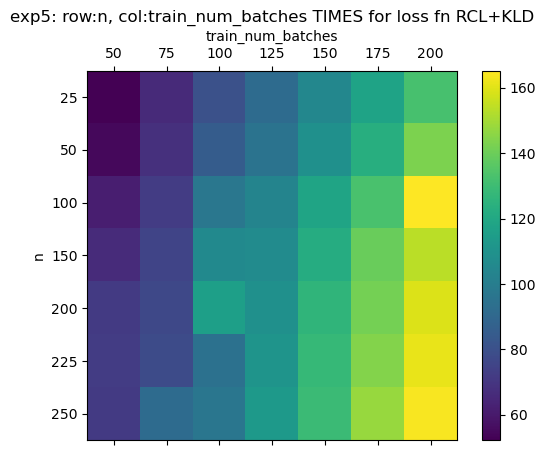

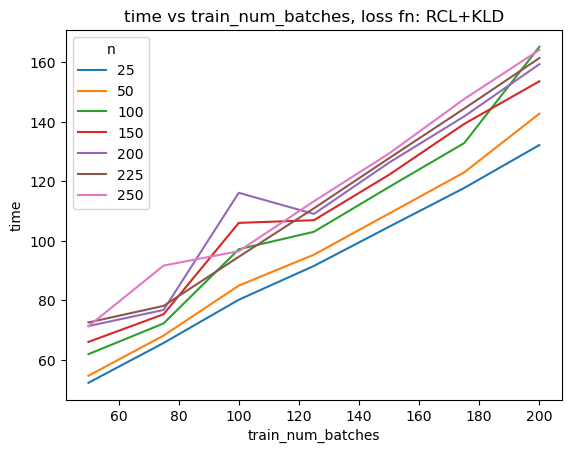

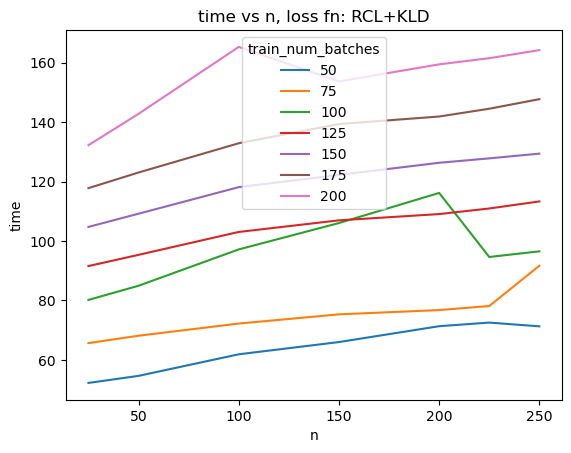

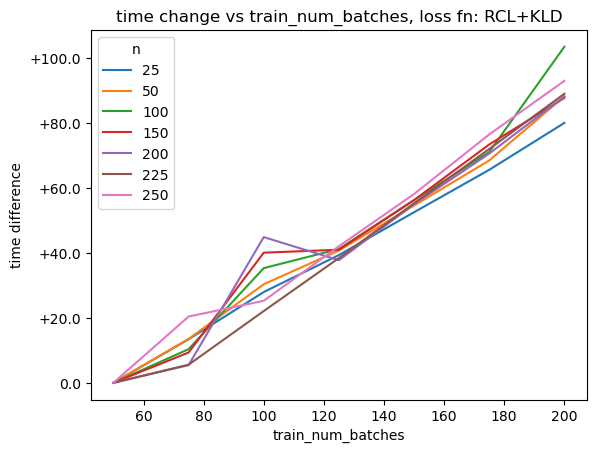

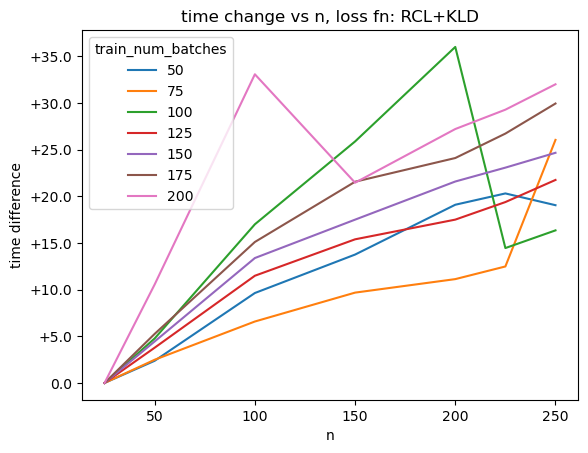

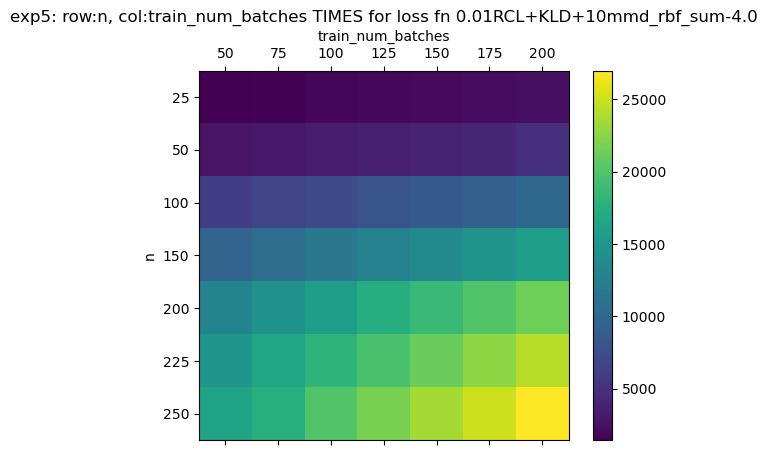

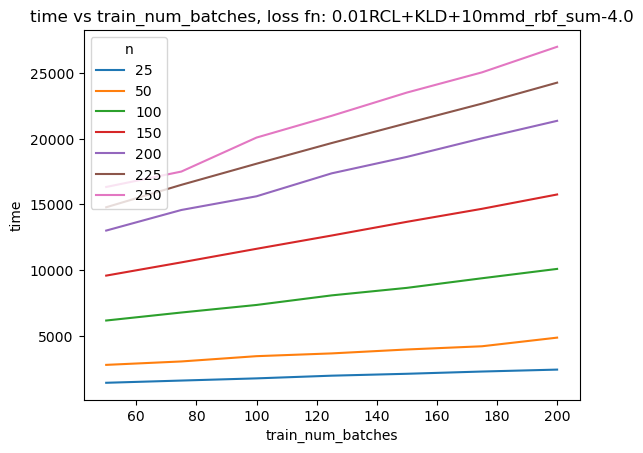

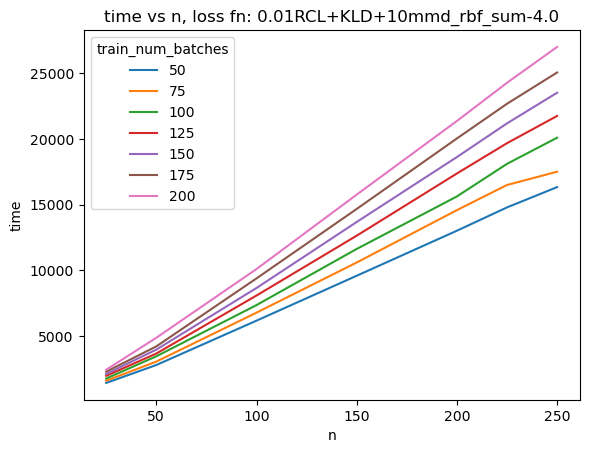

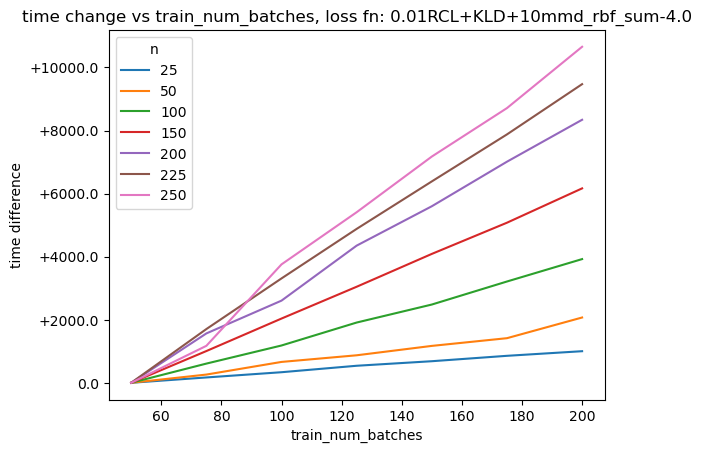

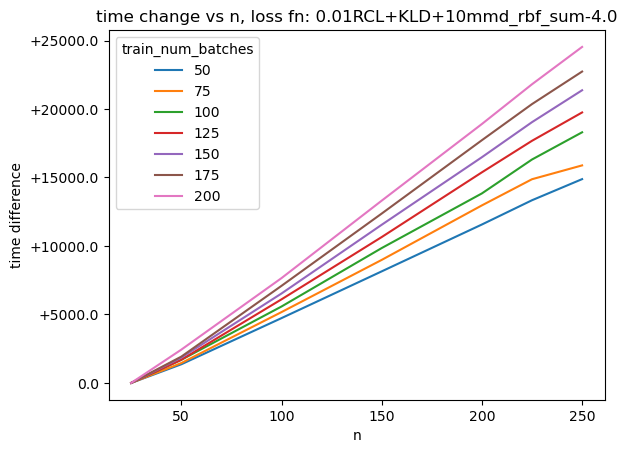

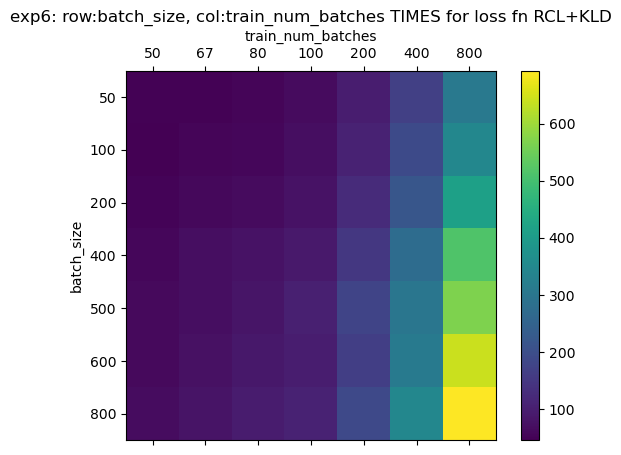

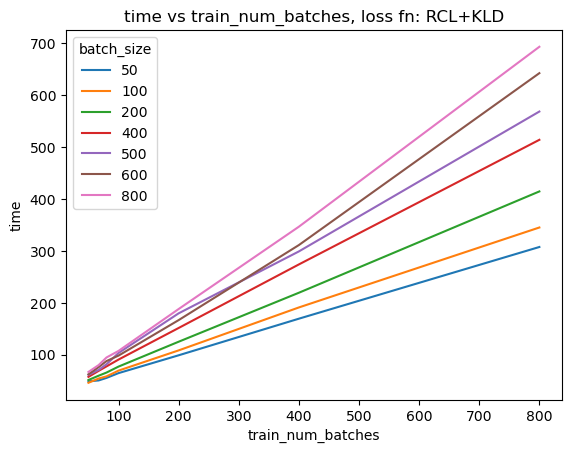

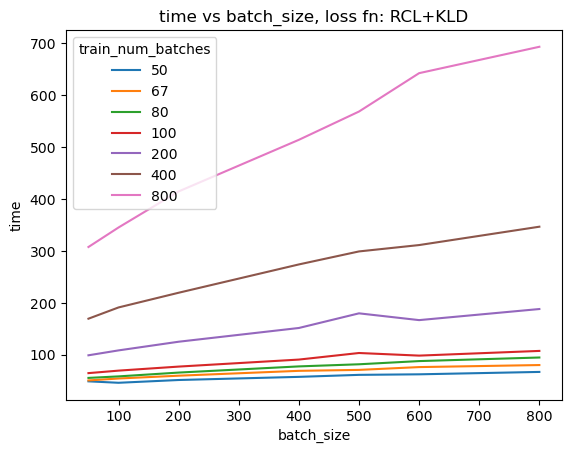

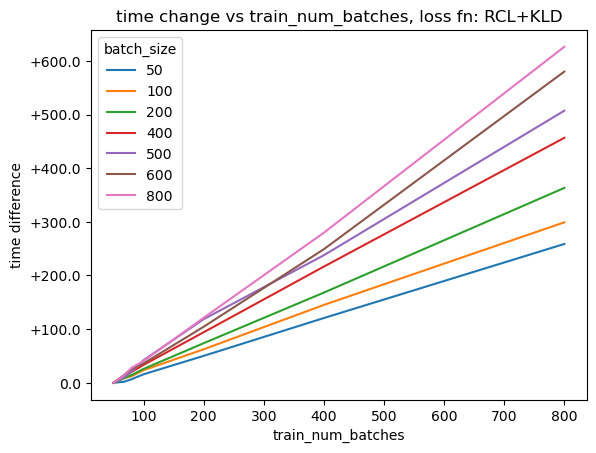

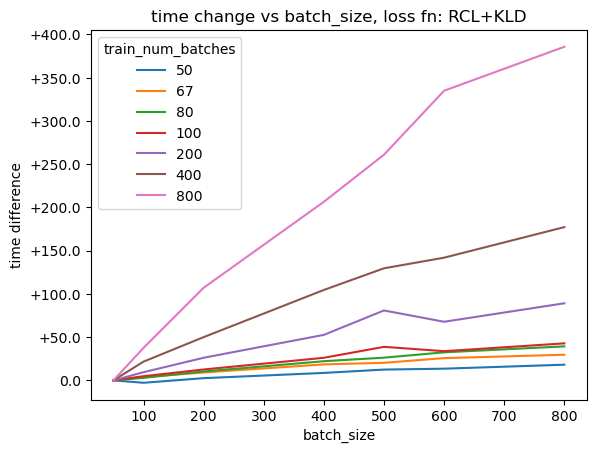

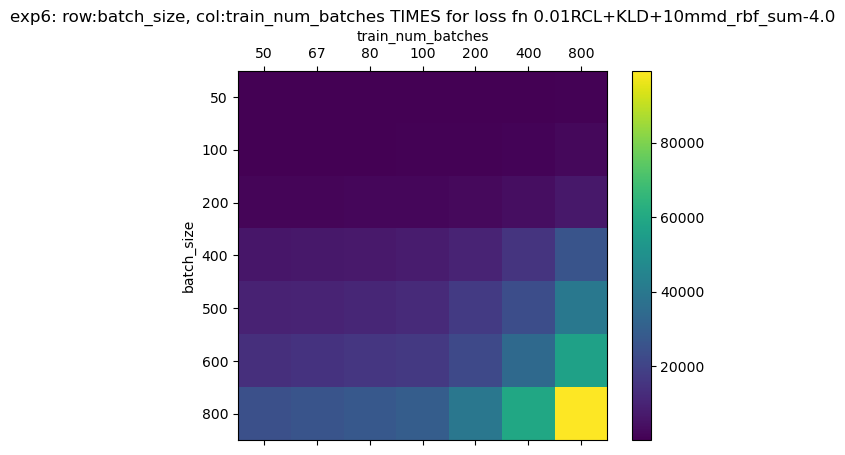

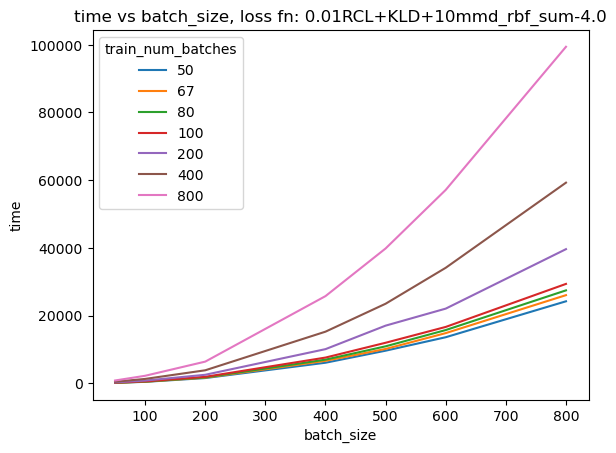

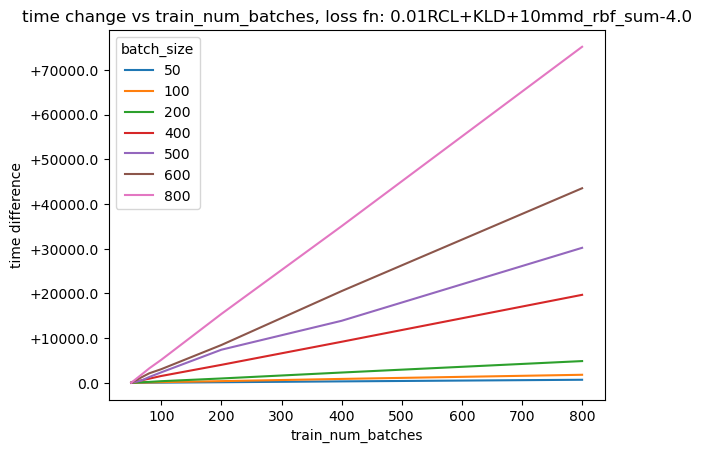

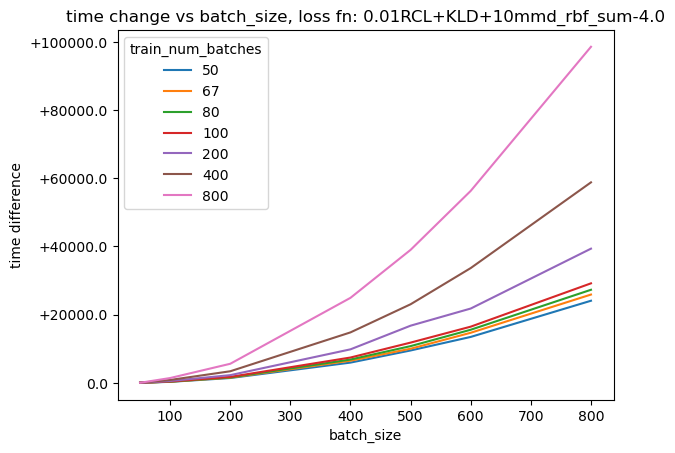

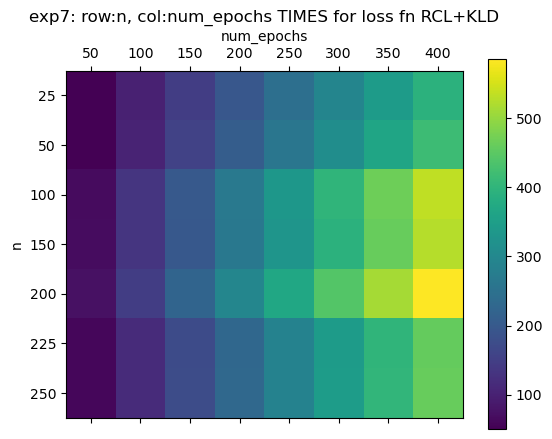

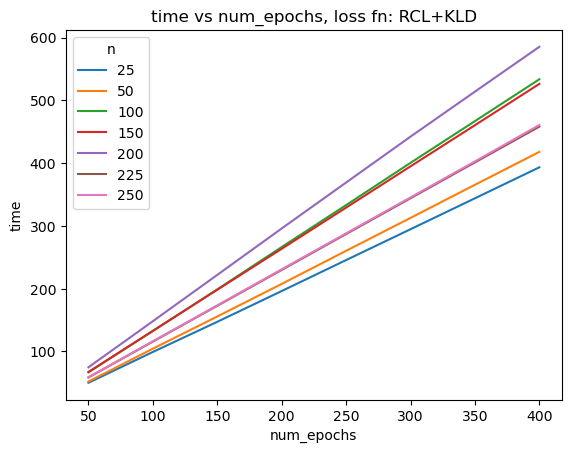

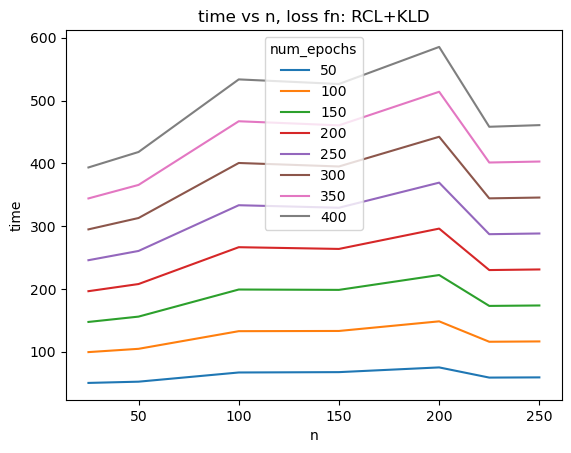

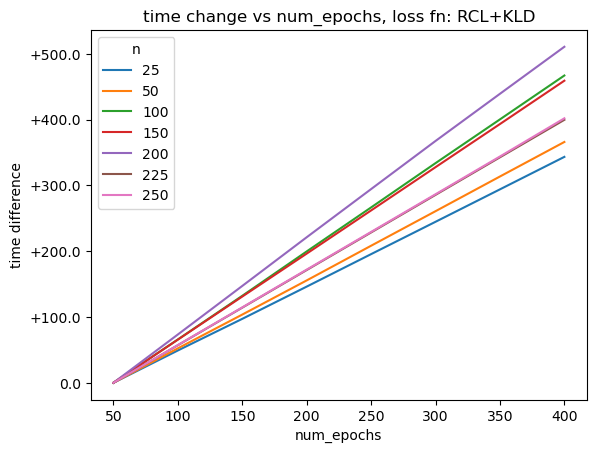

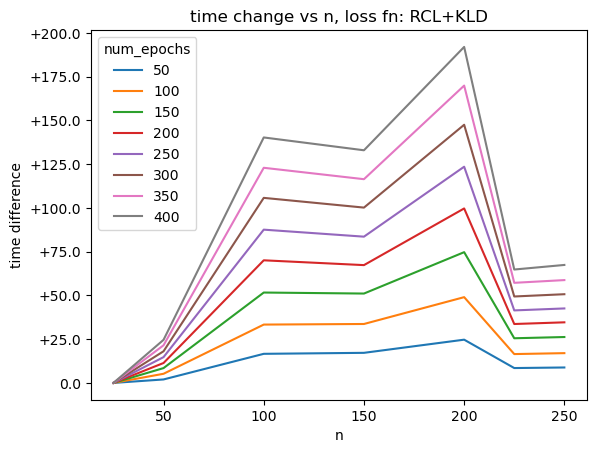

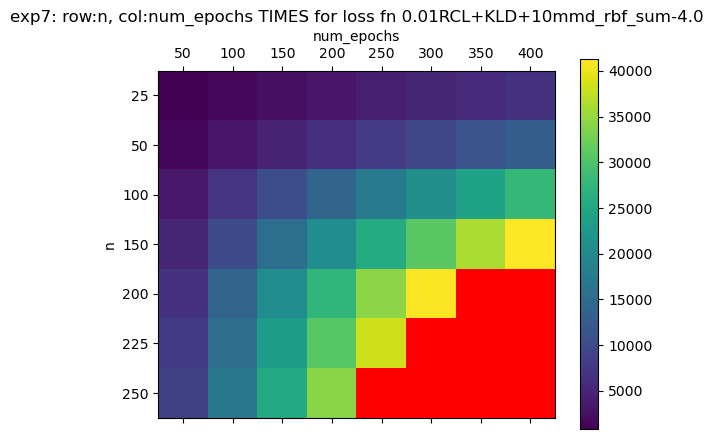

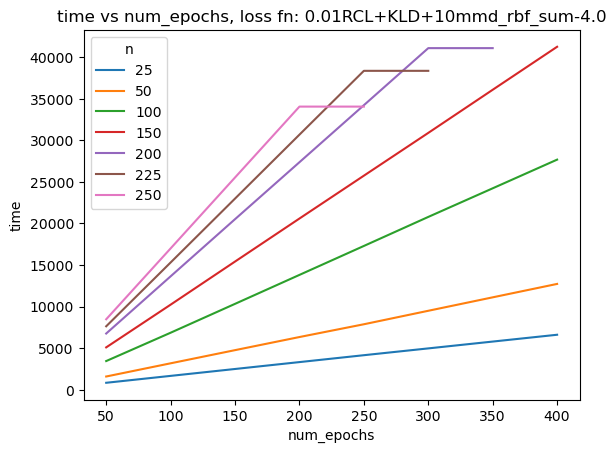

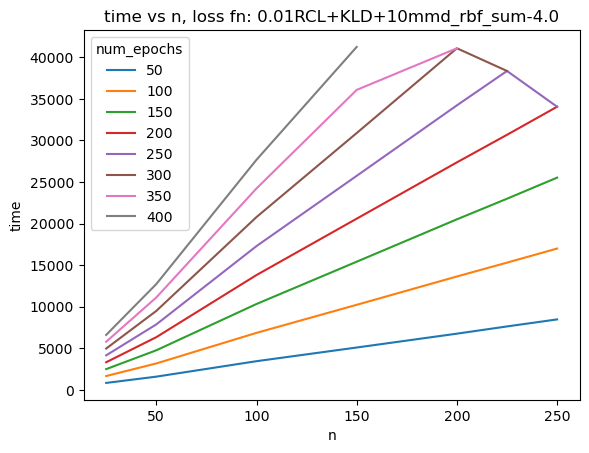

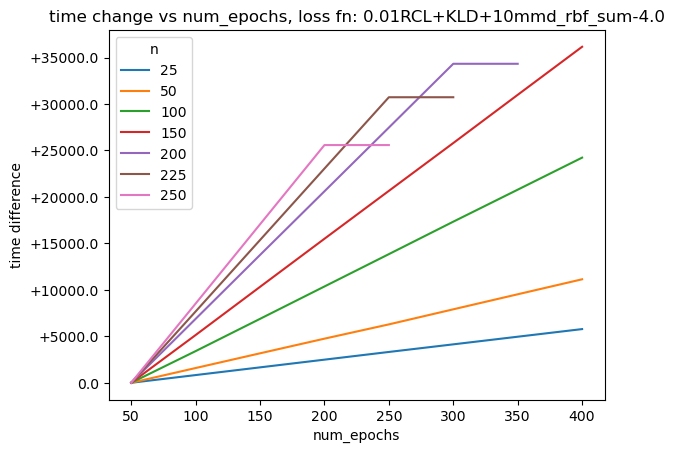

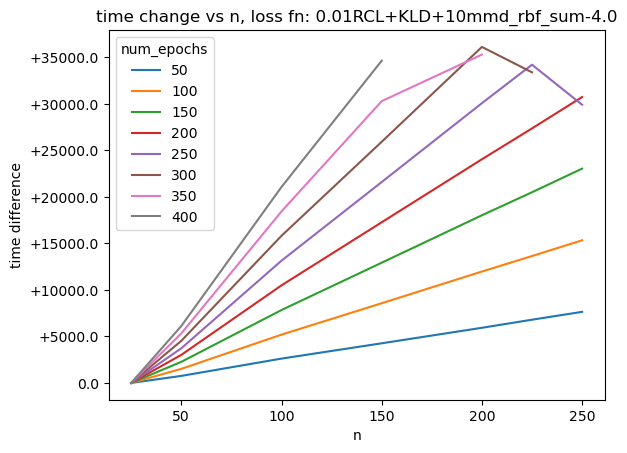

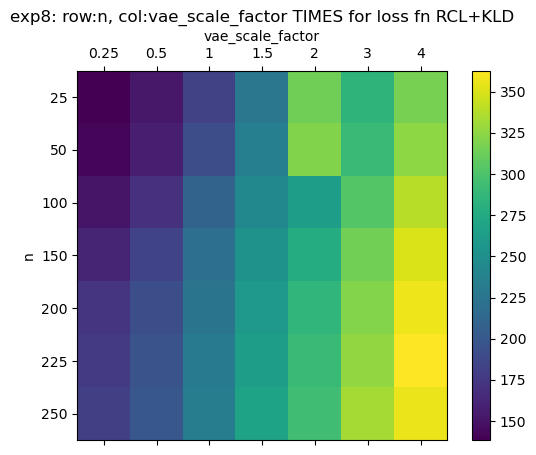

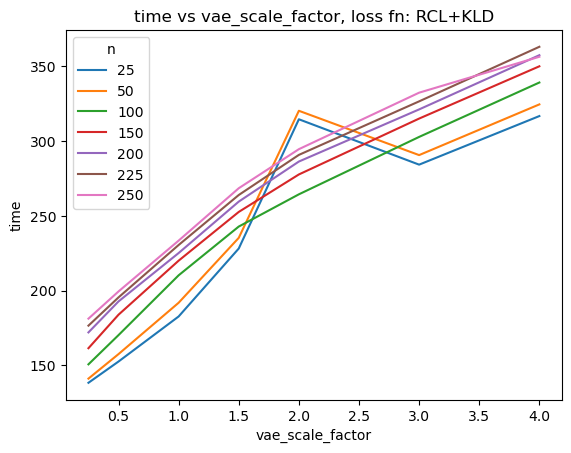

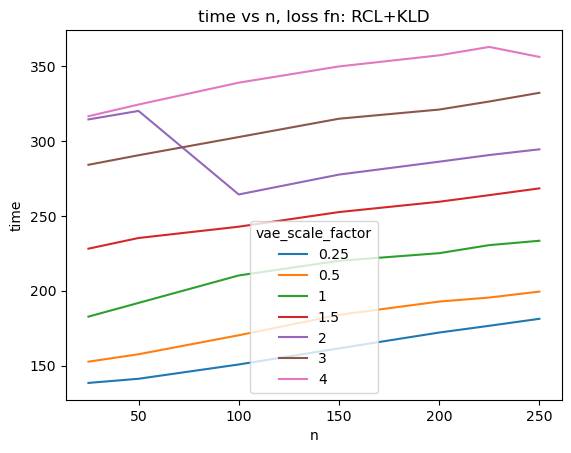

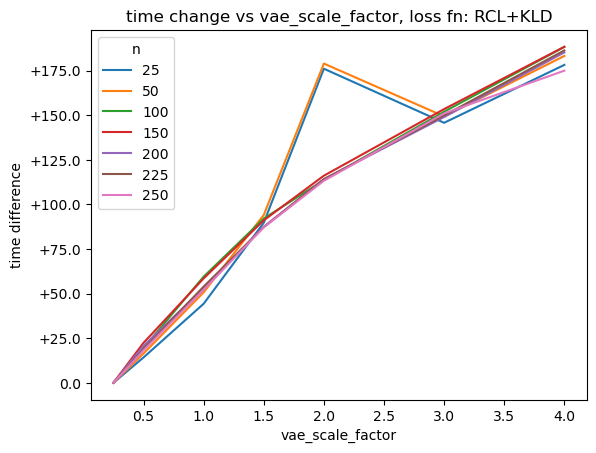

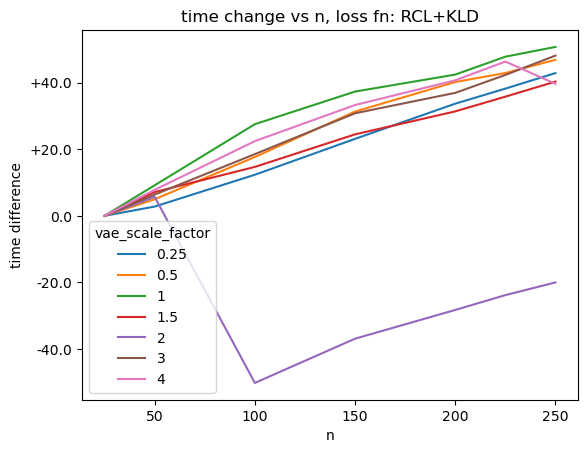

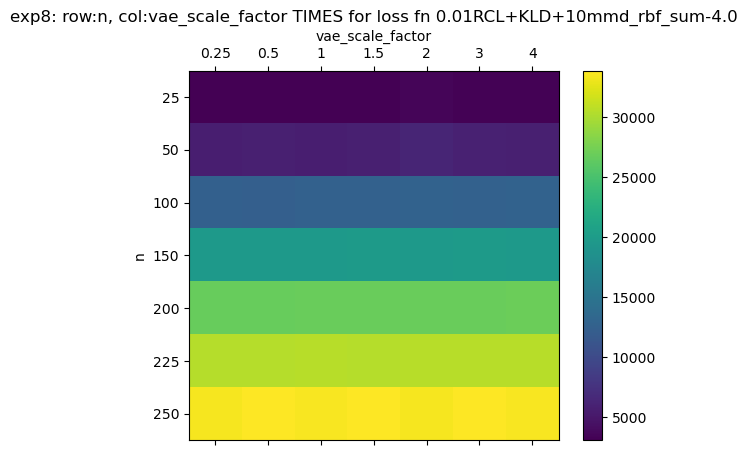

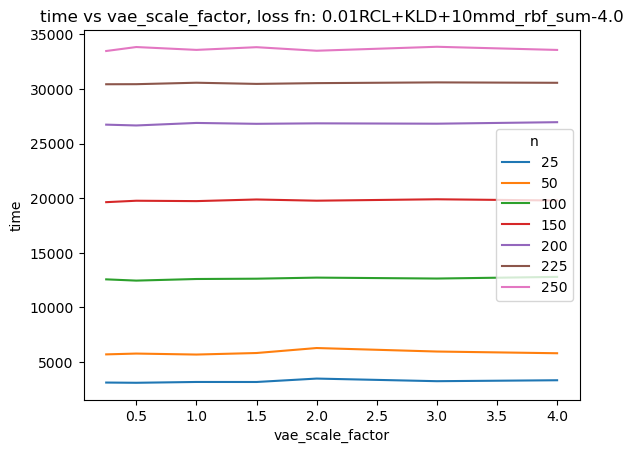

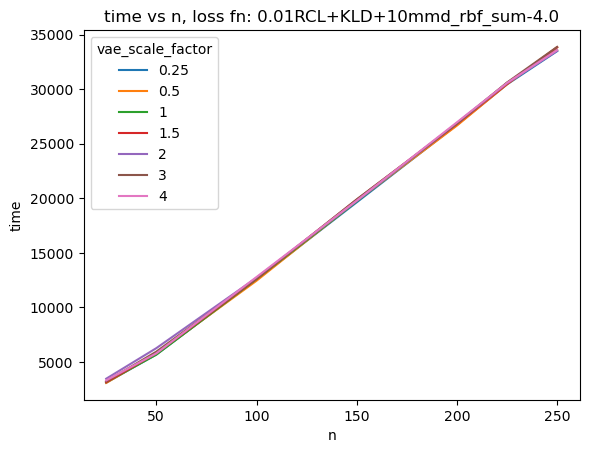

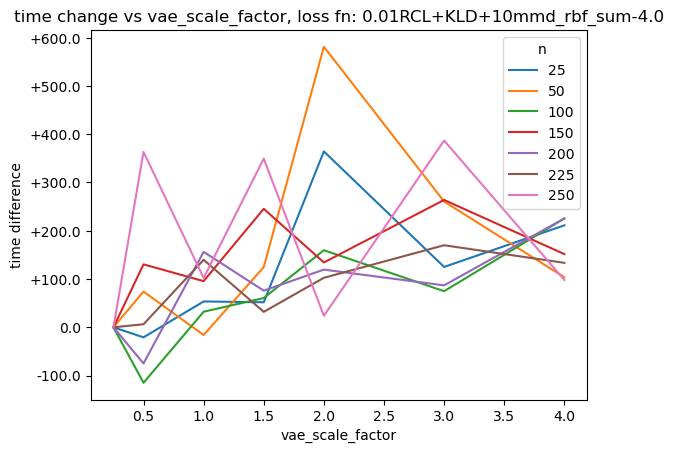

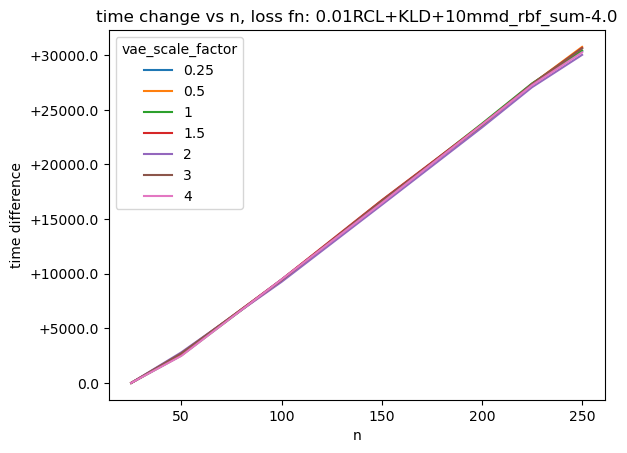

In [23]:

plot_experiment_times("exp5", "4")
plot_experiment_times("exp6", "6")
plot_experiment_times("exp7", "8")
plot_experiment_times("exp8", "12")


Failed to load a=25, b=50
Failed to load a=25, b=100
Failed to load a=25, b=150
Failed to load a=25, b=200
Failed to load a=25, b=250
Failed to load a=25, b=300
Failed to load a=25, b=350
Failed to load a=25, b=400
Failed to load a=50, b=50
Failed to load a=50, b=100
Failed to load a=50, b=150
Failed to load a=50, b=200
Failed to load a=50, b=250
Failed to load a=50, b=300
Failed to load a=50, b=350
Failed to load a=50, b=400
Failed to load a=100, b=50
Failed to load a=100, b=100
Failed to load a=100, b=150
Failed to load a=100, b=200
Failed to load a=100, b=250
Failed to load a=100, b=300
Failed to load a=100, b=350
Failed to load a=100, b=400
Failed to load a=150, b=50
Failed to load a=150, b=100
Failed to load a=150, b=150
Failed to load a=150, b=200
Failed to load a=150, b=250
Failed to load a=150, b=300
Failed to load a=150, b=350
Failed to load a=150, b=400
Failed to load a=200, b=50
Failed to load a=200, b=100
Failed to load a=200, b=150
Failed to load a=200, b=200
Failed to loa

/home/max/4yp/plotting/plots.py:327: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Failed to load a=25, b=50
Failed to load a=25, b=100
Failed to load a=25, b=150
Failed to load a=25, b=200
Failed to load a=25, b=250
Failed to load a=25, b=300
Failed to load a=25, b=350
Failed to load a=25, b=400
Failed to load a=50, b=50
Failed to load a=50, b=100
Failed to load a=50, b=150
Failed to load a=50, b=200
Failed to load a=50, b=250
Failed to load a=50, b=300
Failed to load a=50, b=350
Failed to load a=50, b=400
Failed to load a=100, b=50
Failed to load a=100, b=100
Failed to load a=100, b=150
Failed to load a=100, b=200
Failed to load a=100, b=250
Failed to load a=100, b=300
Failed to load a=100, b=350
Failed to load a=100, b=400
Failed to load a=150, b=50
Failed to load a=150, b=100
Failed to load a=150, b=150
Failed to load a=150, b=200
Failed to load a=150, b=250
Failed to load a=150, b=300
Failed to load a=150, b=350
Failed to load a=150, b=400
Failed to load a=200, b=50
Failed to load a=200, b=100
Failed to load a=200, b=150
Failed to load a=200, b=200
Failed to loa

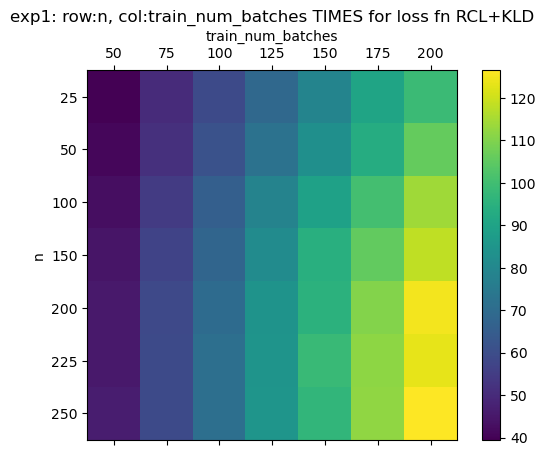

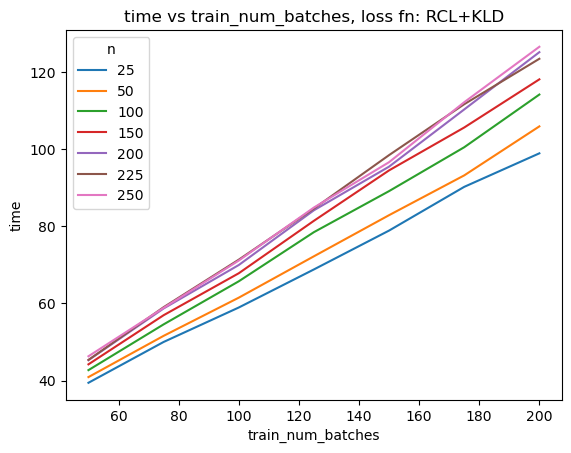

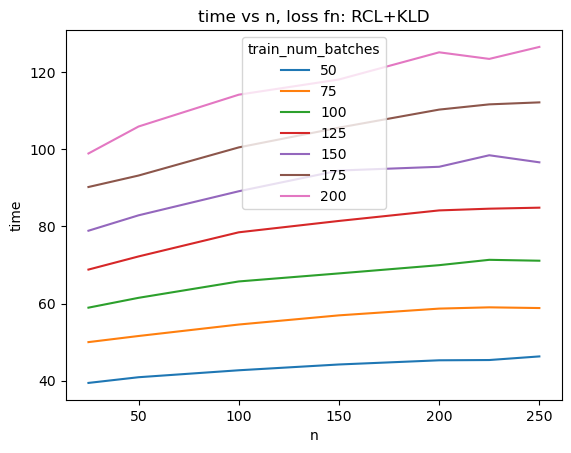

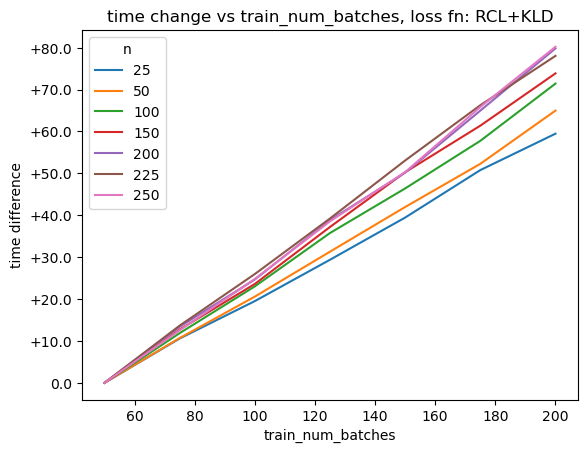

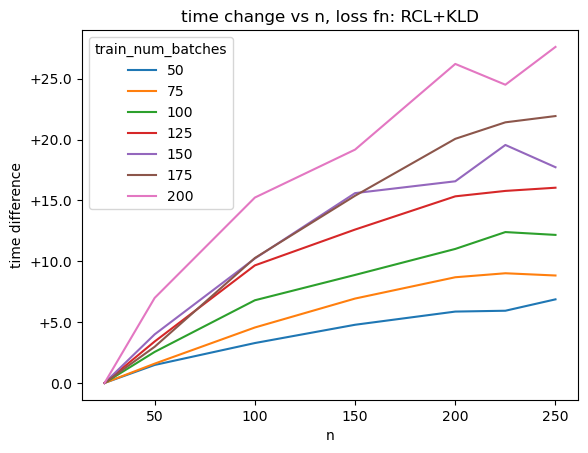

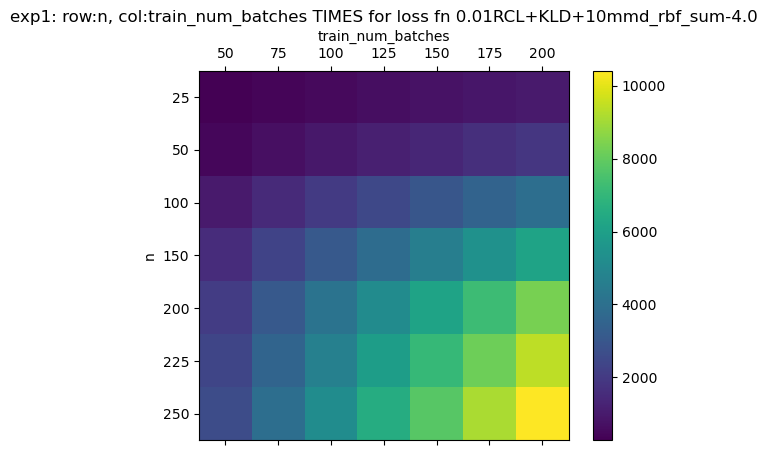

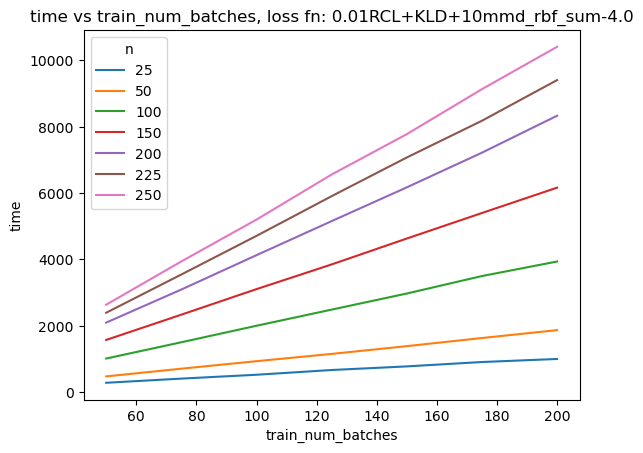

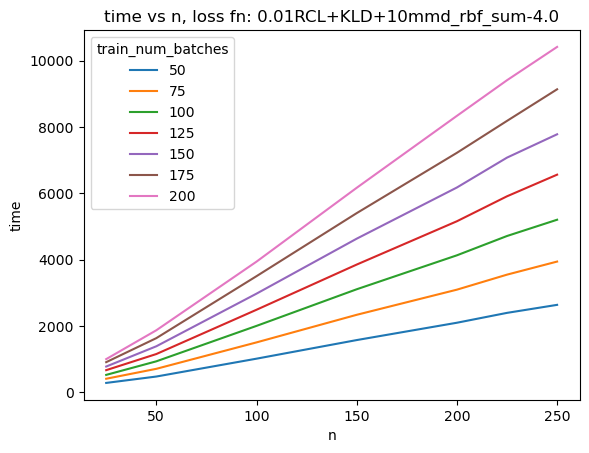

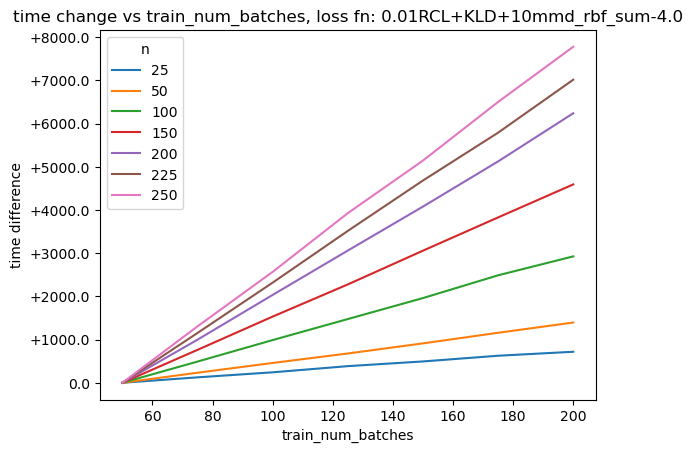

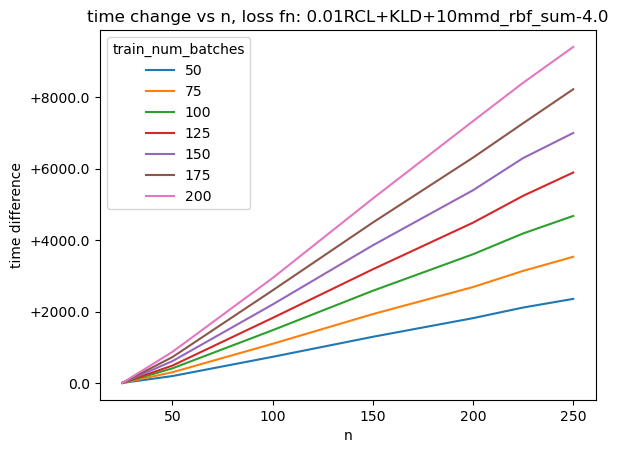

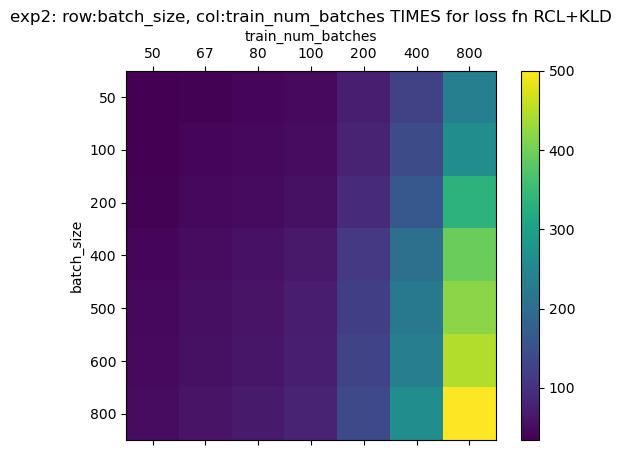

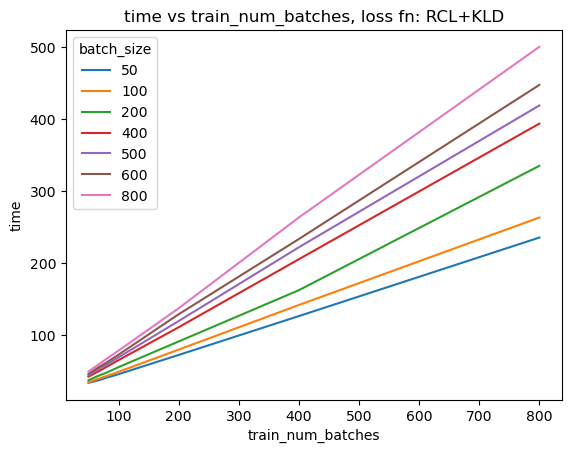

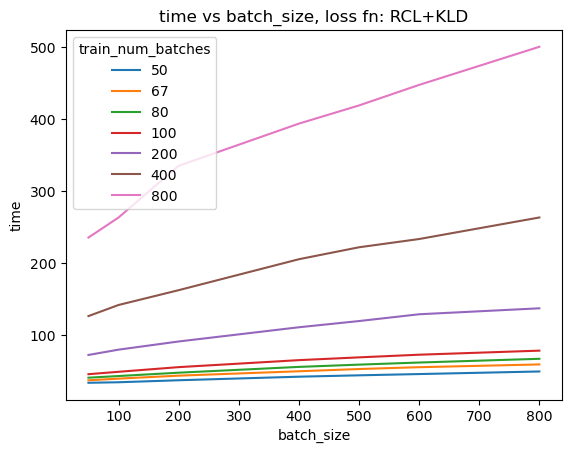

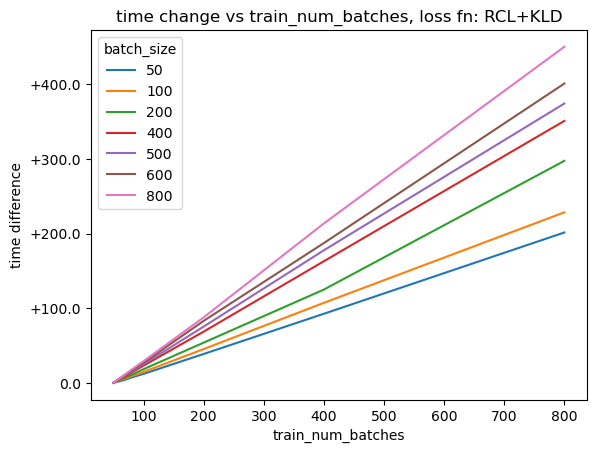

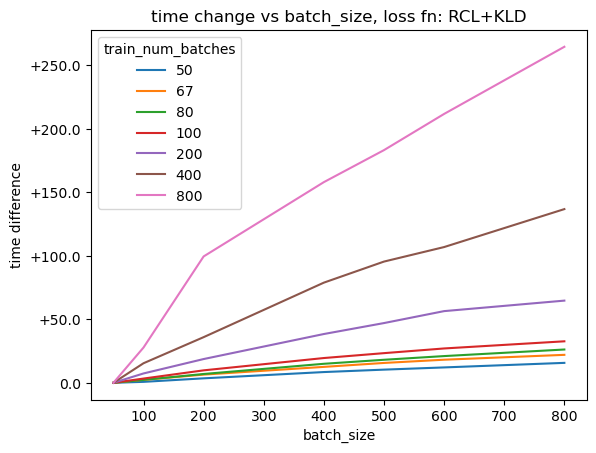

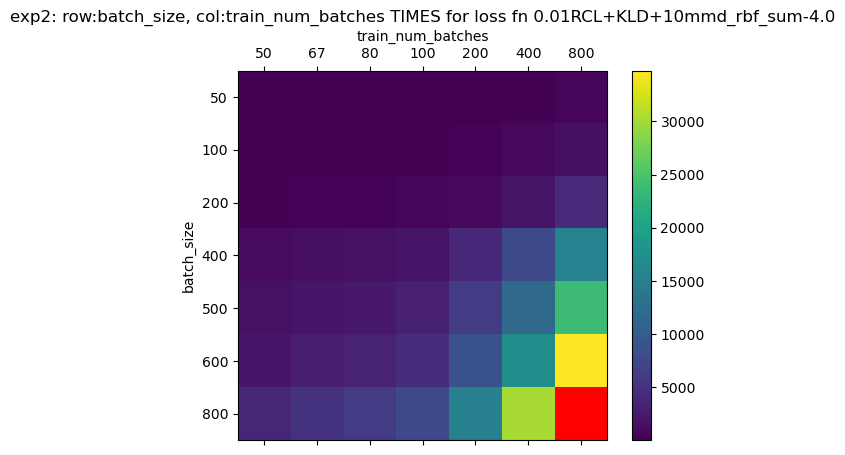

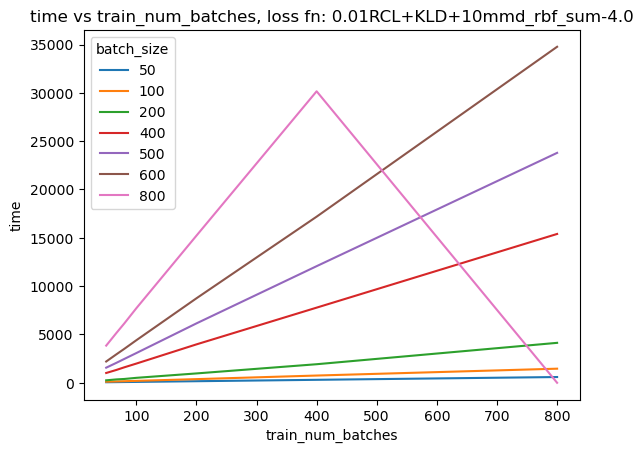

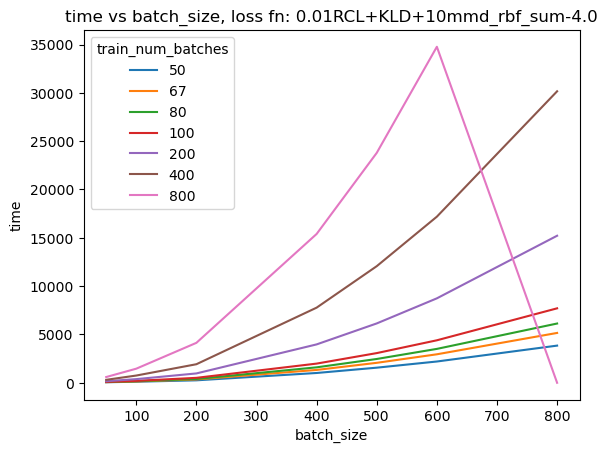

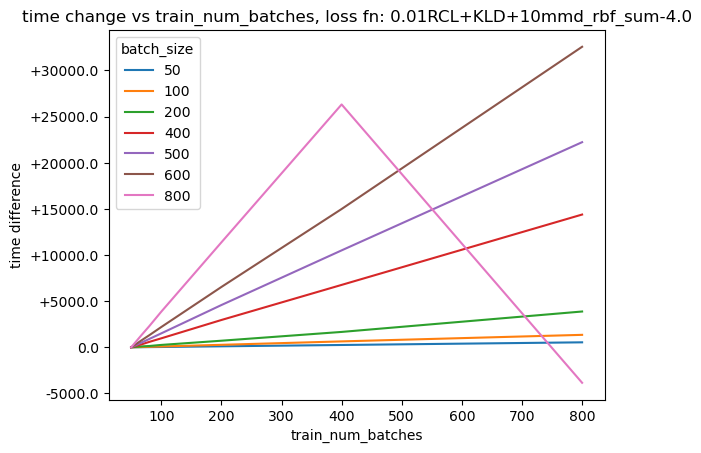

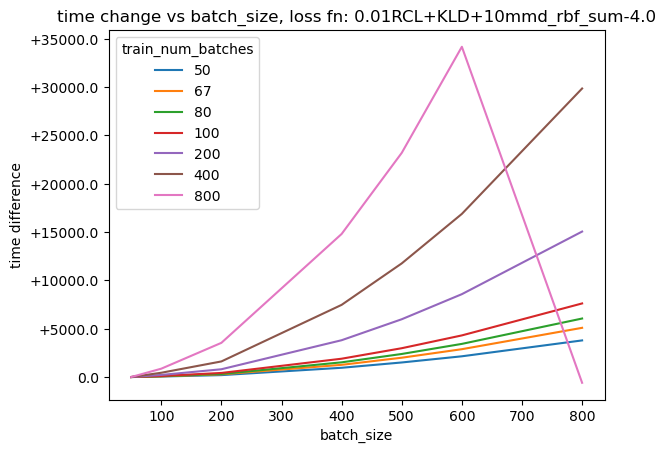

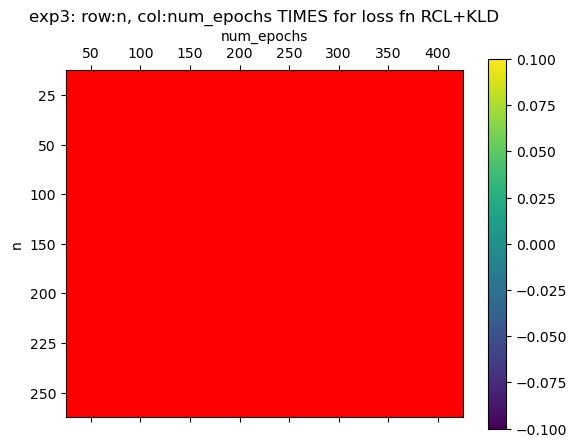

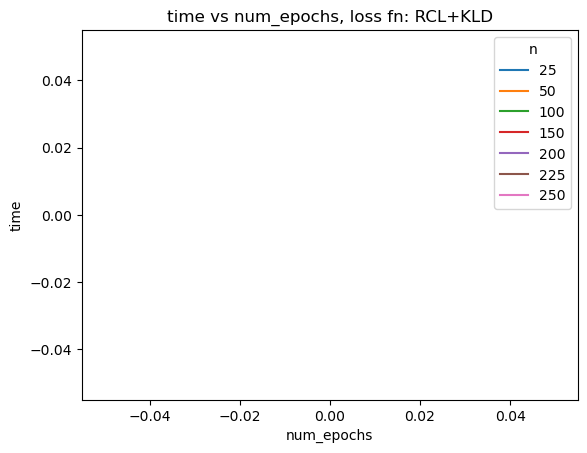

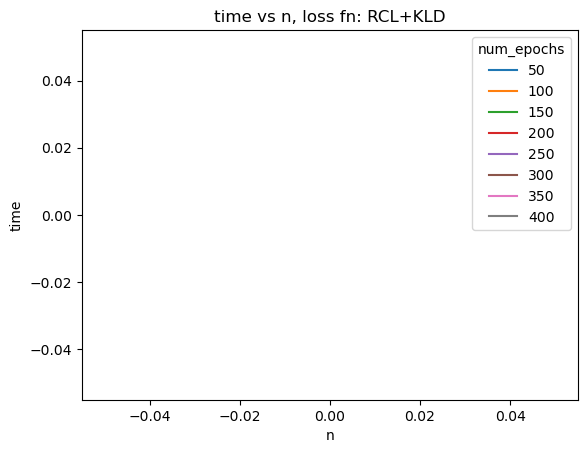

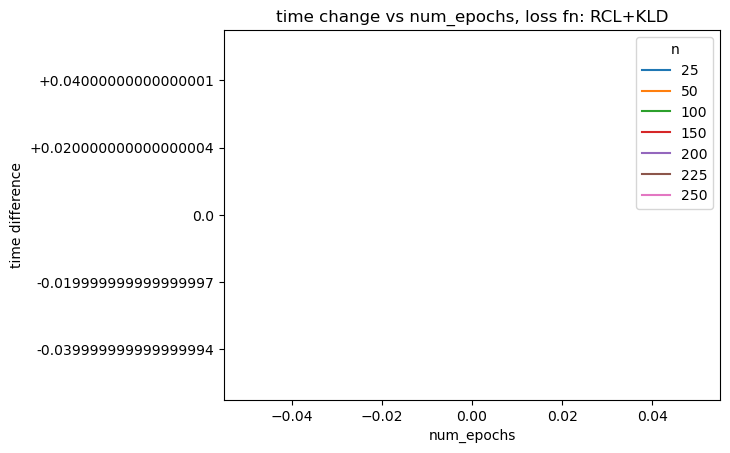

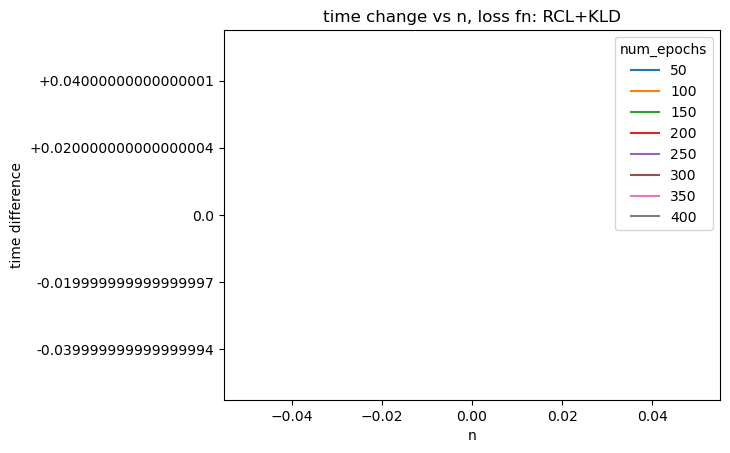

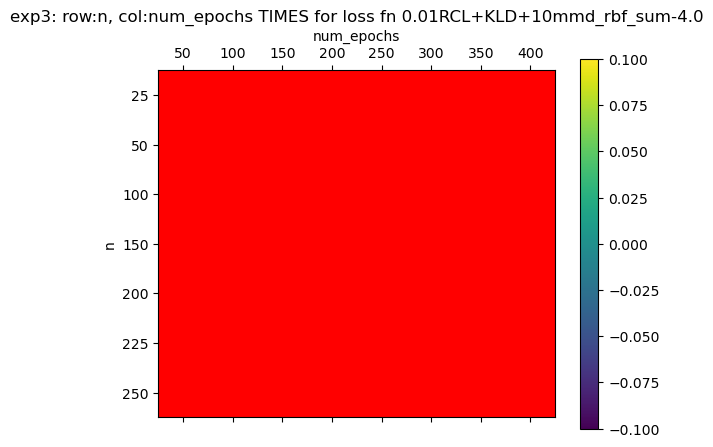

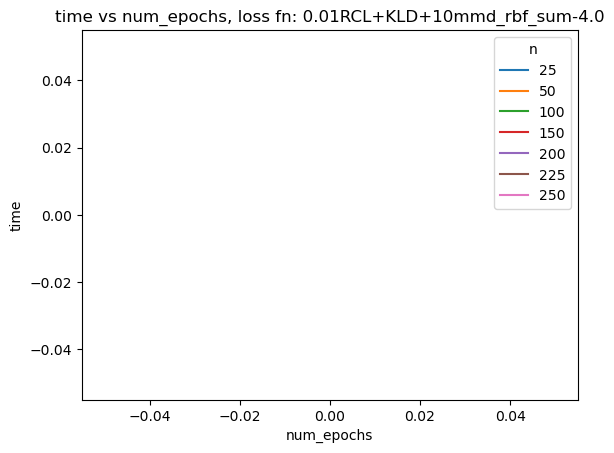

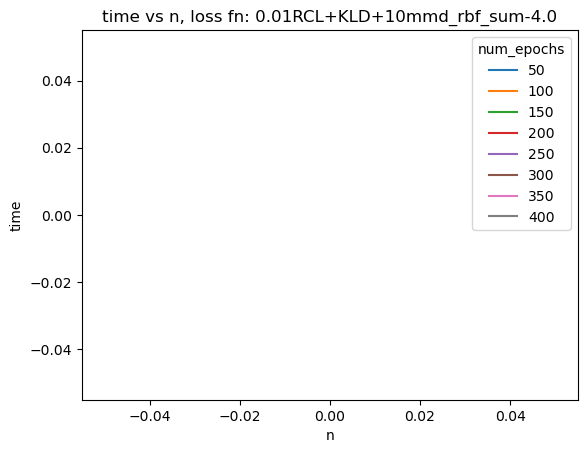

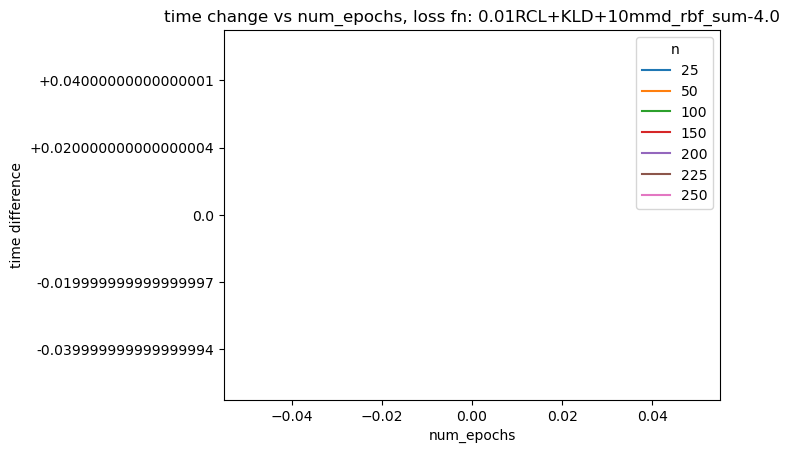

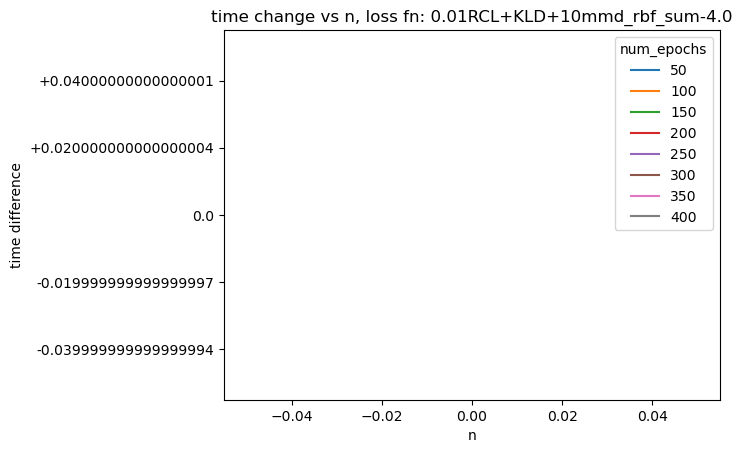

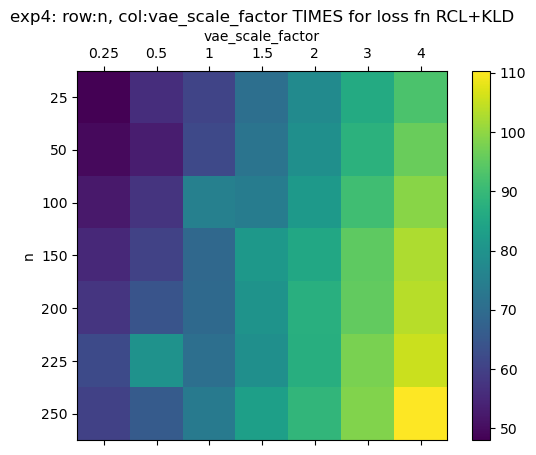

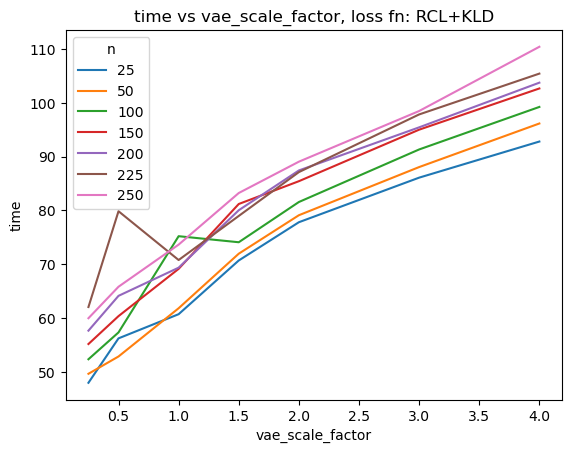

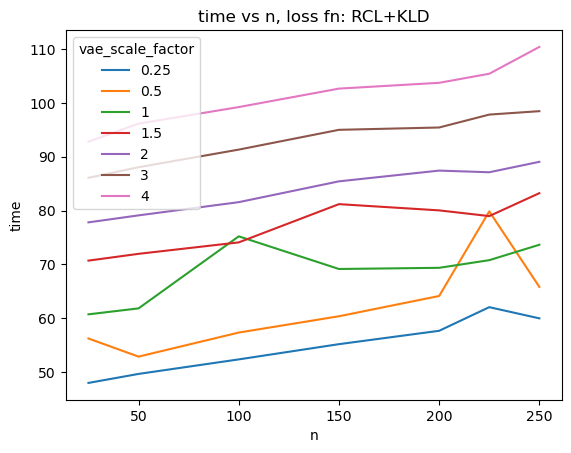

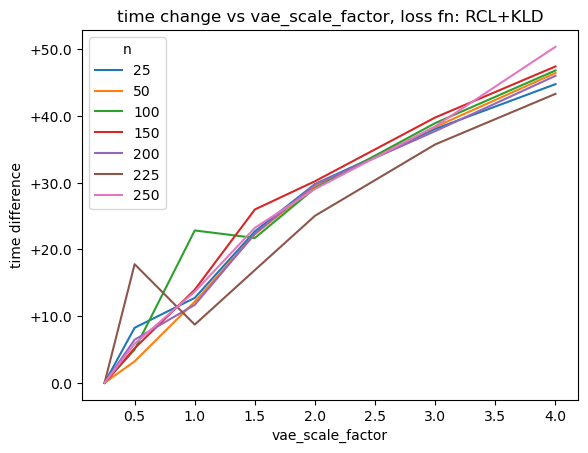

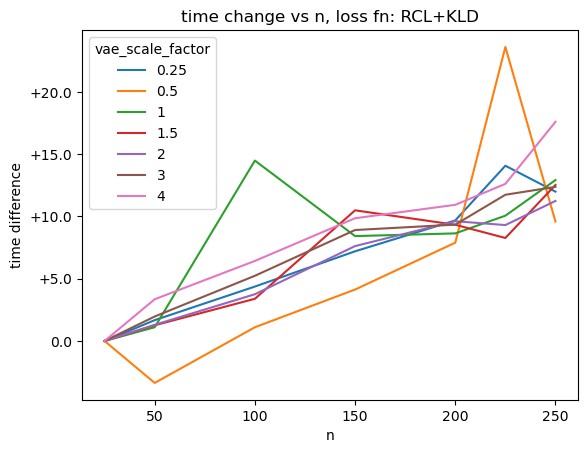

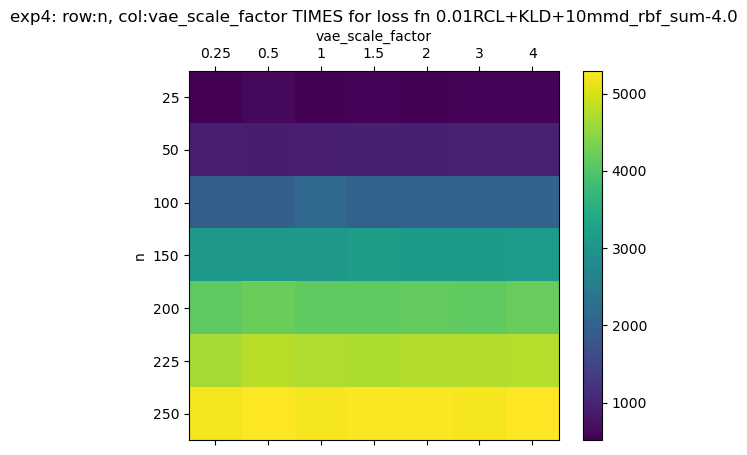

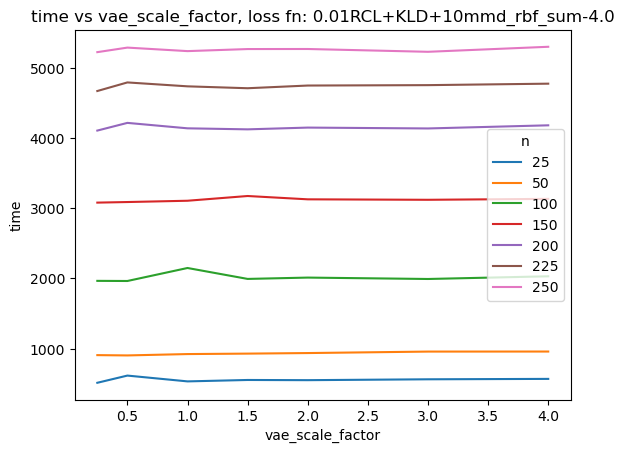

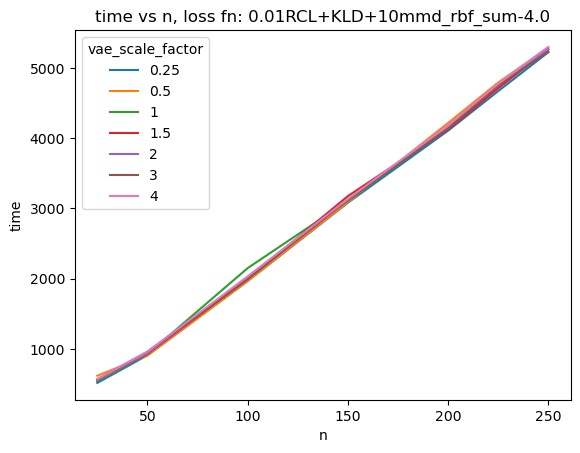

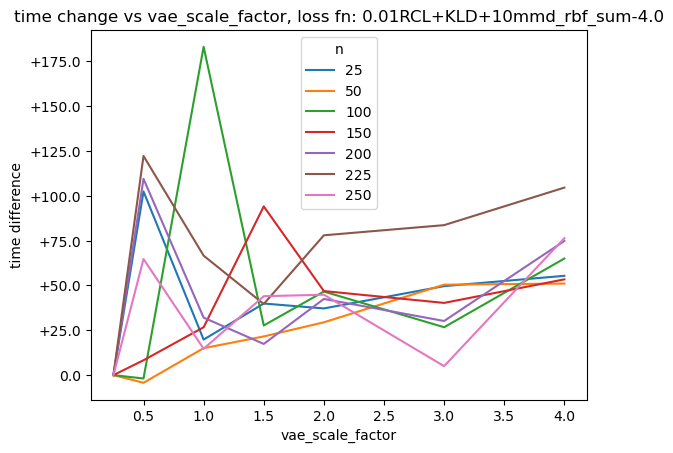

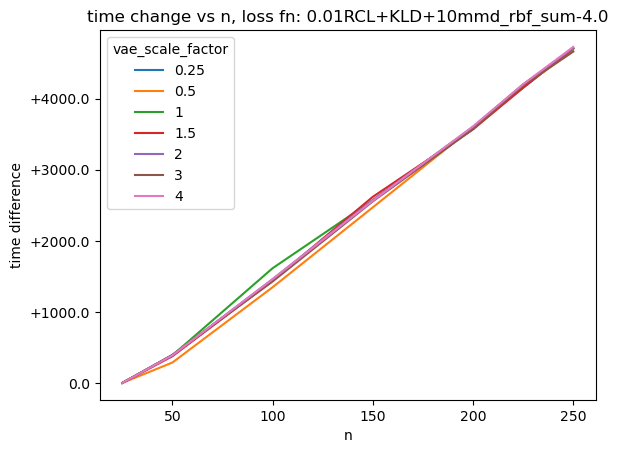

In [24]:

plot_experiment_times("exp1", "1")
plot_experiment_times("exp2", "7")
plot_experiment_times("exp3", "5", needs_timing_correction=True)
plot_experiment_times("exp4", "2")
